# Starbucks Capstone Project

### Pre-Processing
I loaded in the 3 json files described below. I then created dummy columns and altered the column <br>
names so that they were consistent across three dataframes where applicable.

portfolio.json
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

profile.json
- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

transcript.json
- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record



In [93]:
import pandas as pd
import numpy as np, scipy.stats as st
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint



# read in the json files
portfolio = pd.read_json('./data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('./data/profile.json', orient='records', lines=True)
transcript = pd.read_json('./data/transcript.json', orient='records', lines=True)

# portfolio dataframe
dummy_vals = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).groupby(level=0).sum()
portfolio = pd.concat([portfolio, dummy_vals], axis=1)
portfolio.drop(columns='channels', inplace=True)
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

# profile dataframe
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.rename(columns={'id':'customer_id'}, inplace=True)

# transcript dataframe
transcript.rename(columns={'person':'customer_id'}, inplace=True)
transcript['event'] = transcript['event'].str.replace('offer ','')

dummy_vals = pd.get_dummies(transcript['event'])
transcript = pd.concat([transcript,dummy_vals], axis=1)

In [94]:
# create a membership_duration column and calculate duration
profile['membership_duration'] = 0

# get today's date
today = datetime.now()

# simplify the duration to days
profile['membership_duration'] = today - profile['became_member_on']
profile['membership_duration'] = profile['membership_duration'].dt.total_seconds() / (24 * 60 * 60)

# drop became_member_on
profile.drop(columns='became_member_on', inplace=True)

# check for the number of NaN values in profile
print(profile.isna().sum()/len(profile.index)) # income and gender both have NaN values

# exclude NaN values
profile = profile[profile['income'].notna()]

gender                 0.127941
age                    0.000000
customer_id            0.000000
income                 0.127941
membership_duration    0.000000
dtype: float64


In [95]:
# get the counts for how often each messaging platform is used
messaging_platforms = portfolio.groupby('offer_type')['email', 'mobile', 'social', 'web'].sum()

# print the proportion of member genders
print(profile['gender'].value_counts()/profile['gender'].value_counts().sum())

# subdivide the dataframe based on gender
profile_male = profile.loc[profile['gender'] == 'M']
profile_female = profile.loc[profile['gender'] == 'F']
profile_other = profile.loc[profile['gender'] == 'O']


M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64


<ipython-input-95-f1a18092de55>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  messaging_platforms = portfolio.groupby('offer_type')['email', 'mobile', 'social', 'web'].sum()


In [96]:
# merge the transcript and profile dataframes on id
df = pd.merge(transcript, profile, on="customer_id")

# extract unique keys in 'value' column to a seperate column
keys = []
for idx, row in df.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

In [97]:
# create new value columns and specify the datatype
df['offer_id'] = '' 
df['amount'] = 0  
df['reward'] = 0 

# iterate over the dataset and check the 'value' column
# update the new columns using the values
for idx, row in df.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            df.at[idx, 'offer_id'] = row['value'][k]
        if k == 'amount':
            df.at[idx, 'amount'] = row['value'][k]
        if k == 'reward':
            df.at[idx, 'reward'] = row['value'][k]

# fill all the NaNs in the 'offer_id' column with N/A
df['offer_id'] = df['offer_id'].apply(lambda x: 'N/A' if x == '' else x)

# drop the 'value' column 
df.drop('value', axis=1, inplace=True)

In [98]:
# create a new viewed offers dataframe that will be used to filter out the
# completed orders. The assumption is that if a deal is completed but not 
# viewed the marketing effort did not work.
viewed_offers = df.loc[df['event'] == 'viewed']
viewed_offers.drop(['amount', 'transaction', 'viewed', 'received'], axis=1, inplace=True)
viewed_offers = viewed_offers.merge(portfolio.drop('reward', axis=1), 
    left_on='offer_id', right_on='offer_id')

# pull the number of offer_ids that are considered completed
completed_offers = df.loc[df['event'] == 'completed']

# drop the amount and dummy variable columns because there will be no amount associated
# wih the completed tag and we do not need hte dummy var columns for this variable
completed_offers.drop(['amount', 'transaction', 'viewed', 'received'], axis=1, inplace=True)

# merge the completed offers with the user profile 
completed_offers = completed_offers.merge(portfolio.drop('reward', axis=1), 
    left_on='offer_id', right_on='offer_id')

<ipython-input-98-843fc9f61547>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viewed_offers.drop(['amount', 'transaction', 'viewed', 'received'], axis=1, inplace=True)
<ipython-input-98-843fc9f61547>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed_offers.drop(['amount', 'transaction', 'viewed', 'received'], axis=1, inplace=True)


In [99]:
# filter the completed_offers dataframe to only include offers that were both
# viewed and completed
keys = list(['customer_id', 'offer_id'])
i1 = completed_offers.set_index(keys).index
i2 = viewed_offers.set_index(keys).index
completed_and_viewed = completed_offers[~i1.isin(i2)]

# filter the viewed_offers dataframe to remove the offers that were also completed
# filter the completed_offers dataframe to only include offers that were both
# viewed and completed
keys = list(['customer_id', 'offer_id'])
i1 = completed_offers.set_index(keys).index
i2 = viewed_offers.set_index(keys).index
not_completed_viewed = viewed_offers[~i2.isin(i1)]

In [100]:
# combine the two dataframes
cleaned_df = pd.concat([completed_and_viewed, not_completed_viewed])

# Rename the completed column to outcome. The offers viewed and not completed will
# serve as the unsuccessful outcome (0)
cleaned_df.rename(columns={'completed':'outcome'}, inplace=True)
cleaned_df

,customer_id,event,time,outcome,gender,age,income,membership_duration,offer_id,reward,difficulty,duration,offer_type,email,mobile,social,web
3,868317b9be554cb18e50bc68484749a2,completed,468,1,F,96,89000.0,1942.453574,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
18,8a4bc602e4424ab6b16f0b907f2f22af,completed,396,1,M,55,31000.0,1919.453574,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
19,52f0bd64403f4958ab8fe9a6947c13c3,completed,582,1,F,45,44000.0,2603.453574,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
20,1a353048b0884fc5a0afa27677ef1e80,completed,468,1,F,51,56000.0,2038.453574,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
24,d8567f1400d8486cb31c6abba64389ec,completed,606,1,M,38,64000.0,1971.453574,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49855,642dcbae782b41409fe3dfee949800ef,viewed,420,0,M,51,33000.0,1868.453574,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1
49856,612b51c917404bd4a62d46e5b2fedfca,viewed,516,0,M,77,96000.0,1885.453574,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1
49857,7103a340ed8244e1bee58a9639b7678b,viewed,408,0,F,37,90000.0,2757.453574,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1
49858,7103a340ed8244e1bee58a9639b7678b,viewed,582,0,F,37,90000.0,2757.453574,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1


### Visualize the Data

#### Data summary of offers

<AxesSubplot:title={'center':'Offer Duration'}, ylabel='Frequency'>

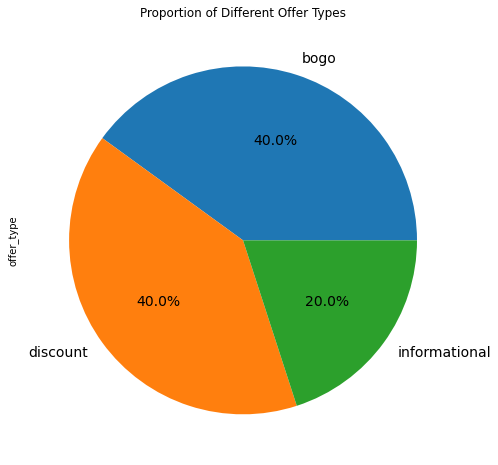

<Figure size 432x288 with 0 Axes>

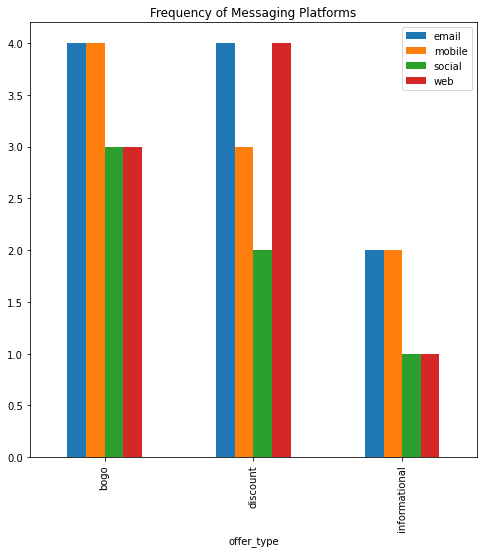

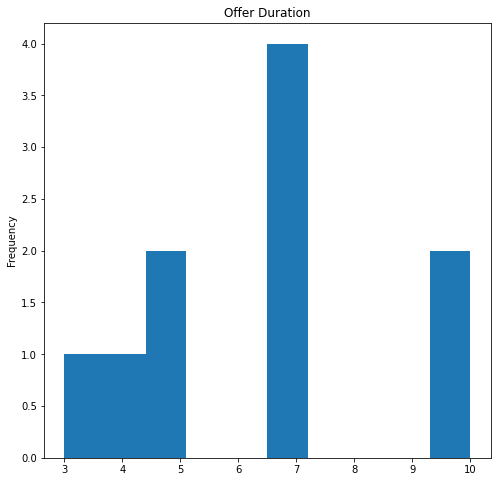

In [101]:
# Get a data summary of the types of offers/ plot the results
# Distribution of offer types
fig = plt.figure()
fig.set_facecolor("white")
portfolio.offer_type.value_counts().plot.pie(
    figsize=(8,8),
    autopct='%1.1f%%',
    textprops={'fontsize': 14},
    title="Proportion of Different Offer Types")

# Distribution of messaging platforms
fig = plt.figure()
fig.set_facecolor("white")
messaging_platforms.plot.bar(figsize=(8,8),
    title="Frequency of Messaging Platforms")

# Offer type versus duration
fig = plt.figure()
fig.set_facecolor("white")
portfolio.duration.plot.hist(
    figsize=(8,8),
    title="Offer Duration"
)

#### Data summary of member demographics

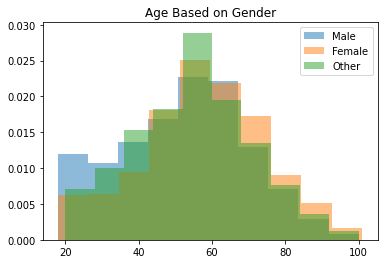

In [102]:
# Plot a histogram of the ages based on gender
plt.hist(profile_male['age'], 
         alpha=0.5, # the transaparency parameter
         label='Male',
         density=True)
  
plt.hist(profile_female['age'], 
         alpha=0.5, # the transaparency parameter
         label='Female',
         density=True)

plt.hist(profile_other['age'], 
         alpha=0.5, # the transaparency parameter
         label='Other',
         density=True)
  
plt.legend(loc='upper right')
plt.title('Age Based on Gender')
plt.show()

In [103]:
print('female age: ', 
    np.mean(profile_female['age']), 
    st.t.interval(0.95, len(profile_female['age'])-1, 
    loc=np.mean(profile_female['age']), 
    scale=st.sem(profile_female['age'])))

print('male age: ', 
    np.mean(profile_male['age']), 
    st.t.interval(0.95, len(profile_male['age'])-1, 
    loc=np.mean(profile_male['age']), 
    scale=st.sem(profile_male['age'])))

print('other age: ', 
    np.mean(profile_other['age']), 
    st.t.interval(0.95, len(profile_other['age'])-1, 
    loc=np.mean(profile_other['age']), 
    scale=st.sem(profile_other['age'])))

female age:  57.54495023658019 (57.12218741370506, 57.96771305945532)
male age:  52.11669024045262 (51.74609004942178, 52.48729043148346)
other age:  54.40094339622642 (52.20161390766539, 56.600272884787444)


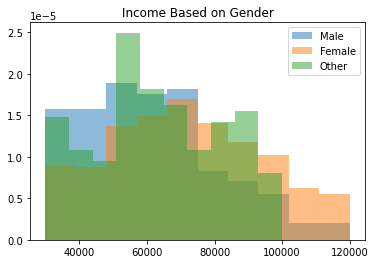

In [104]:
# Plot a histogram of the income based on gender
plt.hist(profile_male['income'], 
         alpha=0.5, # the transaparency parameter
         label='Male',
         density=True)
  
plt.hist(profile_female['income'], 
         alpha=0.5, # the transaparency parameter
         label='Female',
         density=True)

plt.hist(profile_other['income'], 
         alpha=0.5, # the transaparency parameter
         label='Other',
         density=True)
  
plt.legend(loc='upper right')
plt.title('Income Based on Gender')
plt.show()

In [105]:
# calculate and print the confidence intervals for each
# income distribution
print('male income: ', 
    np.mean(profile_other['income']), 
    st.t.interval(0.95, len(profile_other['income'])-1, 
    loc=np.mean(profile_other['income']), 
    scale=st.sem(profile_other['income'])))

print('female income: ', 
np.mean(profile_female['income']), 
st.t.interval(0.95, len(profile_female['income'])-1, 
loc=np.mean(profile_female['income']), 
scale=st.sem(profile_female['income'])))

print('other income: ', 
np.mean(profile_male['income']), 
st.t.interval(0.95, len(profile_male['income'])-1, 
loc=np.mean(profile_male['income']), 
scale=st.sem(profile_male['income'])))

male income:  63287.735849056604 (60723.68829833314, 65851.78339978008)
female income:  71306.41213901126 (70747.05365153107, 71865.77062649145)
other income:  61194.60160301744 (60767.48479222511, 61621.71841380978)


<AxesSubplot:title={'center':'Member Gender'}, ylabel='gender'>

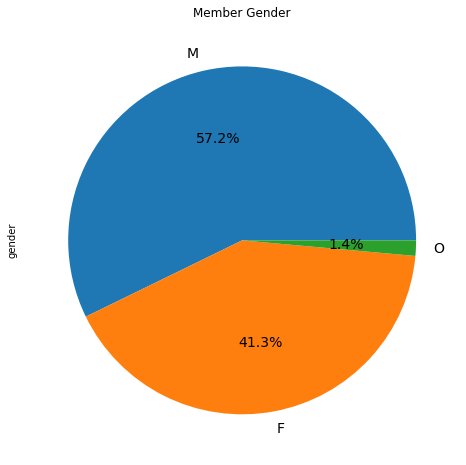

In [106]:
# Get a data summary for the user profile information
profile.isna().sum()/profile.shape[0]

# calculate the percentage of M/ F/ Other/ None
fig = plt.figure()
fig.set_facecolor("white")
(profile['gender'].value_counts()/profile['gender'].value_counts().sum()).plot.pie(
    figsize=(8,8),
    autopct='%1.1f%%',
    textprops={'fontsize': 14},
    title="Member Gender"  
)


transaction    123957
received        66501
viewed          49860
completed       32444
Name: event, dtype: int64

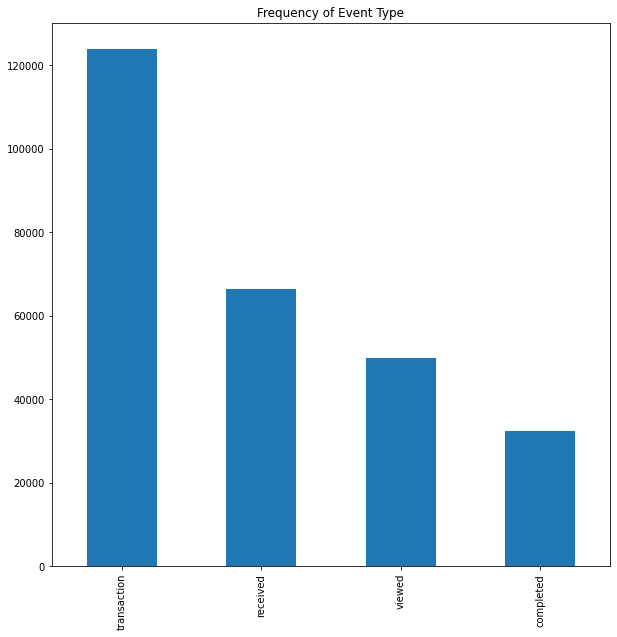

In [107]:
fig = plt.figure()
df.event.value_counts().plot.bar(figsize=(10,10),
    title="Frequency of Event Type")

df.event.value_counts()

### Develop the ML Model
Here we take the cleaned_df created in pre-processing and will use it to create a <br>
machine learning model that will identify key parameters that affect whether an add will be <br>
successful or not.

In [108]:
# Preprocess the df to be used in the ML model
# create dummy var for offer type and gender
dummy_vals = pd.get_dummies(cleaned_df, columns = ['gender', 'offer_type'])
dummy_vals
cleaned_df_ML = dummy_vals.drop(columns=['customer_id', 'event', 'outcome', 'offer_id', 'reward'])

In [109]:
# check to see if the dataset is balanced
print('Number of successes:', cleaned_df['outcome'].sum())
print('Number of Unsuccessful offers:',(cleaned_df['outcome'] == 0).sum())
print('Percent success:', cleaned_df['outcome'].sum()/(cleaned_df['outcome'] == 0).sum())

Number of successes: 4759
Number of Unsuccessful offers: 21627
Percent success: 0.220049012808064


In [110]:
# Define the X and Y variables
X = cleaned_df_ML
Y = cleaned_df['outcome']
category_names = list(X.columns)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [115]:
# create model toggle flag
usingRandomForest = True

#### Logistic Regression Model
The initial ML model developed was a simple logistic regression model. Due to the fact <br>
that the dataset is imbalanced I opted to try using a random forest model as it needs <br>
little pre-processing.

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      4288
           1       0.70      0.28      0.40       990

    accuracy                           0.84      5278
   macro avg       0.78      0.62      0.65      5278
weighted avg       0.83      0.84      0.81      5278



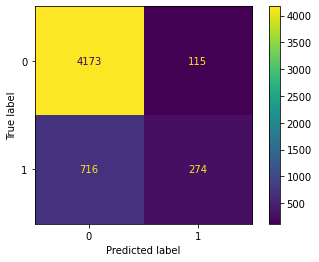

In [113]:
if usingRandomForest == False:

    # build the model for the logistic regression
    model = LogisticRegression(solver='lbfgs',max_iter=10000)  

    # train the model
    model.fit(X_train, Y_train) 

    # test and evaluate the model
    Y_pred = model.predict(X_test)

    # create confusion matrix
    conf_matrix = confusion_matrix(Y_test, Y_pred)

    ConfusionMatrixDisplay(confusion_matrix = conf_matrix).plot()  

    report  = classification_report(Y_test, Y_pred, labels = [0,1])
    print(report)   

    # print(model.steps[0][1].coef_[0])
    # print(X_train.columns)

#### Random Forest Model

The best hyperparameters are: {'max_depth': 8, 'n_estimators': 346}
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4288
           1       0.79      0.78      0.79       990

    accuracy                           0.92      5278
   macro avg       0.87      0.87      0.87      5278
weighted avg       0.92      0.92      0.92      5278



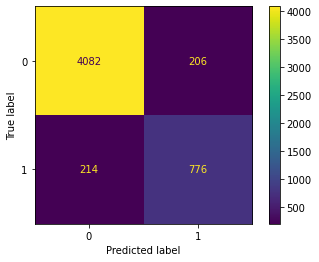

In [117]:
if usingRandomForest == True: 
    # create a random forest classifier
    random_forest = RandomForestClassifier()

    # create parameter distribution
    param_dist = {'n_estimators': randint(50,500),
                  'max_depth': randint(1,10)}

    # find the best hyperparameters
    random_search = RandomizedSearchCV(
        random_forest,
        param_distributions = param_dist,
        n_iter = 10,
        cv = 5
    )

    # fit the random search object
    random_search.fit(X_train, Y_train)

    # identify the best hyperparameters
    ideal_random_forest = random_search.best_estimator_

    print("The best hyperparameters are:", random_search.best_params_)

    # using the best model, generate the predictions
    Y_pred = ideal_random_forest.predict(X_test)

    # create confusion matrix
    conf_matrix = confusion_matrix(Y_test, Y_pred)

    ConfusionMatrixDisplay(confusion_matrix = conf_matrix).plot()

    report  = classification_report(Y_test, Y_pred, labels = [0,1])
    print(report)

<AxesSubplot:>

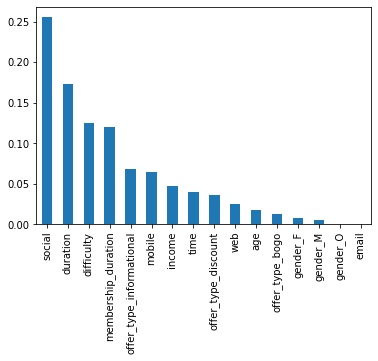

In [118]:
# identify the key parameters/ features that contribute to a successful offer

# feature importances from the model and feature names from the training data
feature_importances = pd.Series(ideal_random_forest.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4323
           1       0.78      0.79      0.79       955

    accuracy                           0.92      5278
   macro avg       0.87      0.87      0.87      5278
weighted avg       0.92      0.92      0.92      5278

